# Inference of $D(c)$ via ISDM
## Learning from [Dandeliion simulation data.](https://simulation.dandeliion.com/legacy/simulation/?id=3865ded1-60e1-439b-82b3-65a0ec8c5b0c)

### [pOCV version]
For the inference, $U_{\rm eq}(c)$ inferred from C/20 charge/discharge data is used (see [notebook](Infer_Ueq_from_pOCV.ipynb)).

Here is the basic premise of this notebook.

- Given $\mathcal{D} = \left\{(t_i, I_i, V_i)_{i=1}^N\right\}$, we divide them into $N_p$ partitions:
$$
\mathcal{D} = \bigcup_{\alpha=1}^{N_p} \mathcal{D}_\alpha
$$
where the $\alpha$th partition is
$$
\mathcal{D}_\alpha = \left\{(t_{i}^\alpha, I_i^\alpha, V_i^\alpha)_{i=1}^{N_\alpha}\right\}
$$
where $N_\alpha$ is the number of data points in the $\alpha$ partition and $\sum_{\alpha=1}^{N_p}N_\alpha=N$.


- We then infer a constant $D_\alpha$ for each set $\mathcal{D}_\alpha$. Since there are overlaps of $c$ in the each chunks, we associate the value of $D_\alpha$ with the average $c$ in the data:
$$
c_\alpha = \frac{1}{\left(t_{N_\alpha}^\alpha - t_{1}^\alpha\right)\,V_{\rm particle}} \int_{t_1^\alpha}^{t_{N_\alpha}^\alpha} dt \int_0^R d^3r\,c^\alpha(t,r)\,,
$$
where $c_\alpha$ is the average concentration for the subset $\alpha$ and $c^\alpha(t,r)$ is the concentration function obtained with the $\alpha$ set.

__This notebook has $\alpha\to N_p$__

For each partition $\alpha\neq1$, the initial concentration is determined from the last concentration in partition $\alpha-1$.

- The results are a set of points $(c_\alpha, D_\alpha)$. We start with the zero-order inferred function by taking the linear interpolation of these points.

- We then scan over $\alpha$ and keep the corresponding value $D_\alpha$ free in the interpolation. We perturb $D$ by $\pm\delta D$ in both directions then choose one of $D\pm \delta D$ and $D$ that minimizes the local loss.

- The local loss for $\alpha$ is determined by including the data from $N_n$ neighbours from the left and right. In general, this involves using $2\,N_n+1$ partitions for any given $N_n< \alpha < N_p -N_n$. For $\alpha$ outside this range, only the available neighbours are used.

- If after this iteration, the global loss does not decrease, the $\delta D$ value is decreased. 

- We repeat the iterations until a) $\delta D$ value goes below a certain tolerance value, or ; b) the change in the global loss is below a certain tolerance value.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import solve_ivp
from scipy.sparse import spdiags
from time import time
# from skopt import gp_minimize
from scipy.interpolate import BSpline
from IPython.display import display, clear_output, HTML
from fetch_Dandeliion import fetch_dandeliion

Read Dandeliion data.

In [2]:
run_url = 'https://simulation.dandeliion.com/legacy/simulation/?id=3865ded1-60e1-439b-82b3-65a0ec8c5b0c'
run_label = 'LGM50_cathode_halfcell_01C'

simulation_save_dir = 'Dandeliion_Simulations/'
inference_save_dir = 'inference_data/'


os.makedirs(inference_save_dir, exist_ok=True) # create the folder for inference results if it doesn't exist

run_folder = simulation_save_dir + run_label+'/'

# If we already downloaded the data, don't bother fetching it. Just read the functions. Otherwise, extract the zip file
dled = os.path.isdir(run_folder)
# Only store D(x) and U_eq(x) in the cathode (we convert Dandeliion's diffusivity to SI units in fetch_diffusivity) and the current used in the submission of the simulation
_, D_c_true, _, Ueq_true, I_data_sub = fetch_dandeliion(run_url, run_label, save_dir= (None if dled else simulation_save_dir))

# Load Dandeliion data files
V_SI = np.loadtxt(run_folder + "voltage.dat", delimiter='\t',skiprows=1, usecols=[0,2])
I_SI = np.loadtxt(run_folder + "current_total.dat", delimiter='\t',skiprows=1, usecols=[0,1])
# Separate, t, I, V data:
t_SI, V_SI = V_SI.T
I_SI = I_SI[:,1]

Read results of GITT and pOCV analysis

In [3]:
# Load GITT-inferred D (not used in ISDM) and U_eq (NOT used in the present ISDM)
df_D_GITT = pd.read_csv(inference_save_dir + "D_GITT_simulation.csv")
df_U_GITT = pd.read_csv(inference_save_dir  + "Ueq_GITT_simulation.csv")
# Load pOCV-inferred U_eq (used in this version)
df_U_pOCV = pd.read_csv(inference_save_dir  + "Ueq_pOCV_simulation.csv")

In [4]:
# Number of partitions
N_partition = 50

Although the first data point is $I=0$, it is good to give boundary conditions and initial conditions that are consistent, so I set the initial index to 0.

In [5]:
idx_in = 0

# Parameters 
Reading from the simulation's `input.log` file.

In [6]:
# Preparing containers for:
# - initial concentrations (anode, cathode), 
# - maximum concentrations (anode, cathode), 
# - particle radii (anode, cathode), 
# - active fraction (anode, cathode, separator), 
# - thicknesses (anode, cathode, separator)

c0_SI, cmax_SI, R_SI, eps_active, L_SI = [], [], [], [], [] 
A_SI = None  # To be read once
x_vals = None

# Mapping keys to containers
key_map = {'cs0': c0_SI, 'cmax': cmax_SI, 'R': R_SI, 'el': eps_active, 'L': L_SI}

def extract_value(s):
    return float(s.split('=')[-1])

# Read and process file
with open(run_folder + "input.log") as f:
    for line in f:
        line_content = line.strip().split('\t')
        key = line_content[0]

        if key in key_map:
            val = extract_value(line_content[-1])
            # Special case for electrolyte fraction 'el' to convert to active material fraction
            key_map[key].append(1 - val if key == 'el' else val)
        elif key == 'A': # Surface area
            A_SI = extract_value(line_content[-1])
        elif key == 'cs_x': # values in the x direction
            x_vals = np.fromstring(line_content[-1].split('=')[-1], sep=' ')

The derived parameters and constants:

In [7]:
F = 96485.3321 # Faraday's constant [C/mol]
# Electrode Volume. 
V_electrode = A_SI*L_SI[1] # Volume [m^3]
area_by_volume_particle = 3/R_SI[1]  # [1/m]
V_particle = 4*np.pi/3*R_SI[1]**3 # Particle volume [m^3]
S_particle = 4*np.pi*R_SI[1]**2 # Particle surface area [m^2]
Np = eps_active[1] * V_electrode / V_particle # Number of active particles
# Contact surface area of electrode with electrolyte
S_contact = eps_active[1] * V_electrode * area_by_volume_particle  # [m^2]


# Code units
- For distance unit, we use the particle radius, i.e. $r_{\rm unit} = R$
- For diffusion unit, we use $D_{\rm unit} = 10^{-15} {\rm m^2/s}$
- For concentration unit, we use the maximum concentration, i.e. $c_{\rm unit} = c_{\rm max}$
- For voltage, we use $V_{\rm unit} = 1{\rm ~V}$
- Time unit can be derived by $t_{\rm unit} = \dfrac{r_{\rm unit}^2}{D_{\rm unit}}$ 
- For current, we make use of the Faraday's constant ($[F] = {\rm C / mol}$), so $I_{\rm unit} = F\,D_{\rm unit}\,c_{\rm unit}\,r_{\rm unit}$
- For molar flux, we similarly have $j_{\rm unit} = \frac{I_{\rm unit}}{F\,r_{\rm unit}^2}$.

In [8]:
# Basic units
r_unit = R_SI[1]
D_unit = 1e-15
t_unit = r_unit**2 / D_unit
c_unit = cmax_SI[1]
I_unit = F * c_unit* D_unit * r_unit  # A
j_unit = I_unit / r_unit**2 /F   # mol/m^2/s
V_unit = 1  # [V]

print(f"t_unit = {t_unit:.5e} s,") 
print(f"r_unit = {r_unit:.5e} m,")
print(f"c_unit = {c_unit:.5e} mol/m^3,")
print(f"I_unit = {I_unit:.5e} A,")
print(f"j_unit = {I_unit:.5e} mol/m^2/s,")
print(f"V_unit = {V_unit:.5e} V")

t_unit = 2.72484e+04 s,
r_unit = 5.22000e-06 m,
c_unit = 5.17650e+04 mol/m^3,
I_unit = 2.60716e-11 A,
j_unit = 2.60716e-11 mol/m^2/s,
V_unit = 1.00000e+00 V


Dandeliion data in code units

In [9]:
V_data = V_SI/V_unit
t_data = t_SI/t_unit
j_data = I_SI / Np / S_particle / F / j_unit # use this only if necessary
j_int = InterpolatedUnivariateSpline(t_data, j_data, k=1)  

True $D(c)$ and true $U_{eq}(c)$ in code units. We also compute the derivative of diffusivity to improve the solution time of the ODE solver. 

In [10]:
from autograd import elementwise_grad
import autograd.numpy as anp

In [11]:
D_true_code =  lambda x: D_c_true(x)/D_unit
D_prime_true_code = elementwise_grad(D_true_code)


Interpolating $D(c)$ and $U_{eq}(c)$ inferred from GITT

In [12]:
# This will be used only for comparison with ISDM
D_GITT = InterpolatedUnivariateSpline(df_D_GITT.c_cmax[::-1], df_D_GITT.D_SI[::-1]/D_unit, k=1, ext=3)
D_GITT_prime = lambda x : D_GITT.derivative()(x)

D_GITT_WH = InterpolatedUnivariateSpline(df_D_GITT.c_cmax[::-1], df_D_GITT.D_wh_SI[::-1]/D_unit, k=1, ext=3)
D_GITT_WH_prime = lambda x : D_GITT_WH.derivative()(x)

# This will be NOT be used in the current ISDM notebook
Ueq_GITT = InterpolatedUnivariateSpline(df_U_GITT.c_cmax, df_U_GITT.Ueq_V, k=1, ext=0)

Interpolating $U_{\rm eq}(c)$ inferred from pOCV

In [13]:
Ueq_pOCV = InterpolatedUnivariateSpline(df_U_pOCV.x, df_U_pOCV.pOCV_V, k=1, ext=0)

### Initial condition for c

In [14]:
c0 = c0_SI[1]/cmax_SI[1]

# ODE System for the diffusion model

We will typically use a constant $D$ for the partitions in this notebook.

However, the functions below are general and allow a function $D(c)$ or $D(c;\theta)$, as long as their derivatives are also provided.


In [15]:
def calc_mass_inv(N, r0):
    """ Calculates the inverse mass matrix for the discrete diffusion equation """
    r = np.linspace(0,r0,N)
    dr = r[1]-r[0]    # radial separation
    non_zero = np.array([ [3/4,]*N, 
                         [1/8,]*(N-1) + [1/4,], 
                         [1/4,] + [1/8,]*(N-1) ])
    diags = np.array([0,1,-1])
    M1 = spdiags(non_zero, diags)
    
    M2 = spdiags([calc_V(N, r0)],[0,])
    M = M1 @ M2
    
    return np.linalg.inv(M.toarray())

In [16]:
def calc_V(N, r0):
    """ Calculates the volumes of discrete shells """
    r = np.linspace(0,r0,N)

    dr = r[1]-r[0]    # radial separation
    V = r**2 * dr + dr**3/12
    V[0] = dr**3 / 24
    V[N-1] = 0.25 * (2 * r0**2*dr - r0*dr**2 + dr**3 / 6)
    
    return V

In [17]:
def calc_RHS(t, c, p):
    # Calculates the RHS of the ODE dc/dt = RHS 
    # c: concentration (vector, spanning the r values)
    # t: time of evaluation (scalar)
    # p: parameters = (DD, DDprime, jj, mas_inv, theta/string)
    #   DD: diffusion function (argument: concentration)
    #   DDprime: derivative of diffusion function wrt c (used in jacobian)
    #   jj: surface flux (to impose Neumann BC at the surface)
    #   if last parameter is the string "fixed", assumes DD(c) and DD'(c)
    #   otherwise reads \theta from last parameter, assuming in DD(c, \theta) and DD'(c, \theta)
    
    dcdr = (c[1:] - c[:-1]) / dr           # dc/dr at r_{i+1/2}, i ∈ {0, ..., N-2}
    cmid = (c[1:] + c[:-1]) / 2            # c at r_{i+1/2}, i ∈ {0, ..., N-2}
    if np.any(p[-1] == "fixed"):
        DD, _, jj, mas_inv, _ = p
        term = DD(cmid) * r2mid * dcdr        
    else:
        DD, _, jj, mas_inv, theta = p
        term = DD(cmid, theta) * r2mid * dcdr        
        
    rhs = np.append(term, -jj(t)) - np.append(0, term) 
    
    return mas_inv@rhs

def jacobian(t,c,p):
    # Jacobian of the diffusion equation, same parameters as calc_RHS
    
    dcdr = (c[1:] - c[:-1]) / dr           # dc/dr at r_{i+1/2}, i ∈ {0, ..., N-2}
    cmid = (c[1:] + c[:-1]) / 2            # c at r_{i+1/2}, i ∈ {0, ..., N-2}
    
    if np.any(p[-1] == "fixed"):
        DD, DDprime, _, mas_inv, _ = p
        term1 = 0.5 * r2mid * DDprime(cmid) * dcdr
        term2 = r2mid * DD(cmid) / dr
    else:
        DD, DDprime, _, mas_inv, theta = p
        term1 = 0.5 * r2mid * DDprime(cmid, theta) * dcdr
        term2 = r2mid * DD(cmid, theta) / dr
    
    # Python requires each diagonal to have same elements, so I add a 0 to the irrelevant parts
    diag_up = np.append(0,term1 + term2)                                        # Ji,i+1
    diag_dn = np.append(-term1 + term2, 0)                                      # Ji,i-1
    diag_mid = np.append(term1 - term2, 0) + np.append(0, -term1 -term2)        # Jii
    
    non_zero = np.array([ diag_mid, diag_up, diag_dn])
    diags = np.array([0,1,-1])

    myjac = spdiags(non_zero, diags)
    
    return mas_inv@(myjac.toarray())

def negative_concentration_event(t, c, p):
    return np.min(c)  # This becomes negative when any concentration is negative
def high_concentration_event(t, c, p):
    return np.max(c) - 1 # This becomes positive when c>1

# Setting the event properties
negative_concentration_event.terminal = True  # Stop the solver if the event occurs
negative_concentration_event.direction = -1   # Event occurs when the value is decreasing

high_concentration_event.terminal = True  # Stop the solver if the event occurs
high_concentration_event.direction = +1   # Event occurs when the value is increasing

my_events = [negative_concentration_event, high_concentration_event]

### Preparation:
- Discretise radial direction
- Compute inverse mass matrix (`scipy` solvers don't support a mass matrix)

In [18]:
N = 30 # Number of radial grid points
r0 = R_SI[1]/r_unit # This is 1 in this case. With multiple electrodes, this can be non-trivial
r = np.linspace(0,r0,N)  # Radial grid
dr = r[1]-r[0]    # radial separation (assumed constant)
r2mid  = (r[1:] + r[:-1])**2 / 4       # r_{i+1/2}^2, i ∈ {0, ..., N-2}
mas_inv = calc_mass_inv(N, r0)

# Partitioning the data:
Here is the plan:

1. Define `DVmin`. Generate list of $t$ for which $\delta V \ge$ `DVmin`.
2. Partition such that there are the same amount of useful points in each partition.
3. Separate the data into chunks based on these boundaries. __Could still uniformly divide along the time axis__. 
4. Store the indices for each partition what the pulse/relax indices are, as well as the $\delta V \ge$ `DVmin` indices.
5. Start from $\alpha=1$. Learn constant $D^{(\alpha)}$ via a zoom-in (coarse-to-fine) grid search.
6. Using the learned $D^{(\alpha)}$, generate $c(r,t_{N_\alpha}^\alpha)$ at the end of the chunk. This is the initial condition for the next chunk.
7. Repeat for $\alpha++$

__Only for GITT--like partitioning:__ Manually provide the partition boundaries. Set the partitions such that each contain an integer number of GITT periods. [not in this notebook]


In [19]:
def distribute_gitt_periods(idx_switch, N_partition):
    """ Given indices for gitt switches (including the last data index), divide them into
    N_partition partitions such that there are only two unique number of elements per partition"""     
    switch_on = idx_switch[::2]
    # Assuming last point is included
    N = len(switch_on)-1
    quotient, remainder = divmod(N, N_partition)

    first_elements = [switch_on[i * quotient + min(i, remainder)] for i in range(N_partition)]
    # Also add the last point and return :
    return np.sort(list(set(first_elements) | {idx_switch[-1]}))

def partition_time(t, N_chunks, idx_threshold):
    # For remn-1 partitions, the number of elements will be quot+2, for the remaining ones it is quot+1. Remember that the boundaries overlap in the partitions.
    # These cover all data points, with N_partition -1 inner boundaries repeated.
    # Might seem opaque, but trust myself, it works.
    quot = len(idx_threshold)//N_chunks
    remn = len(idx_threshold)%N_chunks
    if remn == 0: # if the size of mask divisible by N_chunks:
        quot -=1
        remn += N_chunks # this is done because the inner boundaries are repeated.
    # indices of boundaries:    
    idx_knots = np.hstack([idx_threshold[:(quot+1)*(remn-1)+1:quot+1] , idx_threshold[(quot+1)*(remn-1)+quot::quot]])
    # List of partitions of t, with overlapping boundaries
    t_chunks = [t[idx_knots[idx]:idx_knots[idx+1]+1] for idx in range(N_chunks)]
    return idx_knots, t_chunks

def partition_data(Q, idx_knots):
    N_chunks = len(idx_knots)-1
    Q_chunks = [Q[idx_knots[idx]:idx_knots[idx+1]+1] for idx in range(N_chunks)]
    return Q_chunks

In [20]:
set_GITT=set_useGITTperiods = 0
# Set up the partitions.
# For gitt-like partitioning, just use the switch points to set them up. Otherwise equally distribute points which have Delta V > Dvmin.
if set_GITT and set_useGITTperiods:
    idx_threshold = distribute_gitt_periods(idx_switch, N_partition)
elif set_GITT:
    DVmin = 2.e-4 
    # Use a boolean mask to determine where increase is above threshold. 
    # Add a False to the beginning to compensate for diff removing one element
    mask_threshold = np.r_[False, (np.diff(V_charge)) >= DVmin]
    # any point prior to idx_in is removed
    mask_threshold[:idx_in]=False
    # Just in case, add the first (idx_in) and last (-1) data points
    mask_threshold[idx_in]=True
    mask_threshold[-1] = True
    # These are the indices of the good data points.
    idx_threshold = np.where(mask_threshold)[0]
elif set_useGITTperiods:
    print("Something wrong here. Signal declared non-GITT but GITT-like partitions requested.")
else:
    # For constant current, divide the data evenly in t-axis
    t_total = t_data[-1] - t_data[idx_in]
    dt_partition = t_total/N_partition
    idx_threshold = [idx_in,]
    for i in range(1, N_partition):
        idx_right = np.where(t_data >= t_data[idx_in] + i*dt_partition)[0][0]
        idx_threshold += [idx_right]
    # Add the final data point:
    idx_threshold += [len(t_data)]
    idx_threshold = np.array(idx_threshold)
    
    pass
# Get partition boundaries and partitioned time
idx_parts, t_parts = partition_time(t_data, N_partition, idx_threshold)
j_parts = partition_data(j_data, idx_parts)
V_parts = partition_data(V_data, idx_parts)

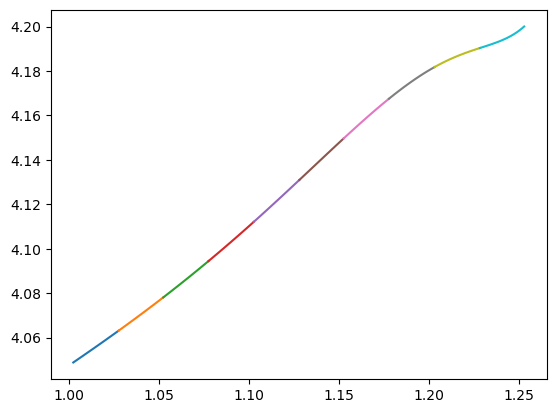

In [21]:
for i in range(40,50):
    plt.plot(t_parts[i],V_parts[i])
plt.show()

### Determine the duration of pulses in each partition.
This will be useful for the ODE solver as some partitions have shorter pulses.

In [22]:
dt_max_parts = np.ones(N_partition)*((t_data[-1]- t_data[idx_in])/N_partition)
dt_max_global = np.min(dt_max_parts)

## Visualise the partitions

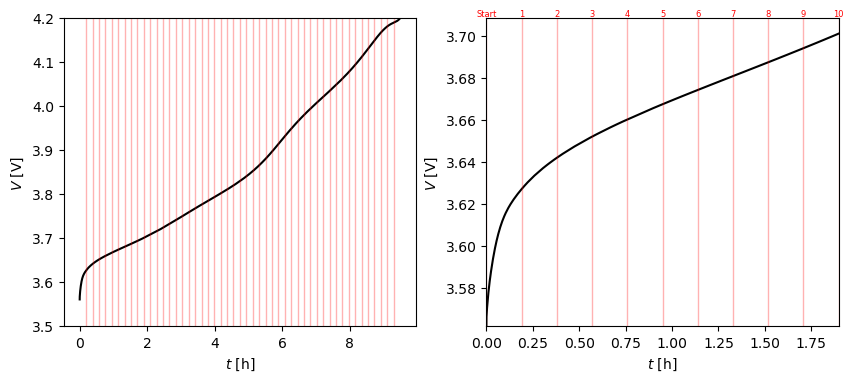

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
part_max = 10
plt.plot(t_SI/3600, V_SI, 'k-')
plt.vlines(t_SI[idx_parts[1:-1]]/3600, 2.50, 4.25, color='r', lw=1, alpha=0.3)
plt.xlabel(r"$t$ [h]")
plt.ylabel(r"$V$ [V]")
plt.ylim([3.5,4.2])

plt.subplot(1,2,2)
plt.plot(t_SI/3600, V_SI, 'k-')
plt.vlines(t_SI[idx_parts[:-1]]/3600, 2.50, 4.25, color='r', lw=1, alpha=0.3)
# Add counters for each line

Vrange = np.hstack(V_parts[:part_max+1])
Vmin, Vmax = np.min(Vrange), np.max(Vrange)

for i, x in enumerate(t_SI[idx_parts[1:part_max+1]]/3600):
    plt.text(x, Vmax, str(i + 1), color='r', ha='center', va='bottom',fontsize='6')

plt.text(t_SI[idx_parts[0]]/3600, Vmax, "Start", color='r', ha='center', va='bottom',fontsize='6')

plt.xlabel(r"$t$ [h]")
plt.ylabel(r"$V$ [V]")
plt.xlim([0,t_parts[part_max][0]*t_unit/3600])
plt.ylim([Vmin, Vmax])
plt.show()

### Define minimisation algorithm 

In [24]:
zerofunc = lambda x: 0
def predict(DD, j, t_grid, c_in, dt_max):
    """Predict the surface concentration for diffusion constant D, 
    at times t_grid, with initial concentration c_in, forced by flux function j
    """
    Dfunc = lambda x: DD
    csol = solve_ivp(calc_RHS, [t_grid[0], t_grid[-1]], c_in, t_eval = t_grid, method='LSODA', 
                    jac = jacobian, args = ((Dfunc, zerofunc, j, mas_inv, "fixed"),),
                    events=my_events,
                    max_step= dt_max,
                    rtol=1.e-5,
                    atol=1.e-8
                    )
    return csol

def find_minimum(Dscan, func):
    funcvals = [func(DD) for DD in Dscan]
    return np.argmin(funcvals)

def improve_minimum(Dold, delD, Npoints, func, iters):
    Dnew = Dold # We will improve this minimum
    for i in range(iters):
        Dlow = Dnew - delD # Look only in the vicinity of the minimum
        Dhigh = Dnew + delD
        delD = 2*delD / Npoints # new separation
        Dscan = np.linspace(Dlow, Dhigh, Npoints+1) # new grid
        idx_min = find_minimum(Dscan, func)
        Dnew = Dscan[idx_min] # new minimum
        mse = func(Dnew)
    return Dnew, mse

def search_minimum(part, Dlow, Dhigh, Npoints, func, iters=1, fail_counter=2, fail_widen=1, fail_factor=10):
    delD = ( Dhigh - Dlow ) / Npoints
    Dscan = np.linspace(Dlow, Dhigh, Npoints+1)
    
    idx_min = find_minimum(Dscan, func)
    
    success = not np.any(idx_min == np.array([0, Npoints]))
    Dest = Dscan[idx_min]
    
    if success:
        Dest, mse = improve_minimum(Dest, delD, Npoints, func, iters)

    else: # If we couldn't find the minimum, then
        counter = 0 
        print(f"No minimum found at partition #{part}.")
        N_failed = Npoints # We will increase the number of points
        Dlow_failed, Dhigh_failed = Dlow, Dhigh # and widen the range
        while (not success) and (counter <fail_counter):
            Dlow_failed -= fail_widen
            Dhigh_failed += fail_widen
            N_failed *= fail_factor
            print(f"Widening the search to [{Dlow_failed}, {Dhigh_failed}] with {N_failed} points...")
            Dscan = np.linspace(Dlow_failed, Dhigh_failed, N_failed+1)
            idx_min = find_minimum(Dscan, func)
            success = not np.any(idx_min == np.array([0, N_failed]))
            counter += 1
        # did it work?
        if success:
            print("Success!")
            delD = (Dhigh_failed - Dlow_failed) / N_failed # the separation we used
            Dest = Dscan[idx_min]
            # now we can iterate to improve upon this point.
            Dest, mse = improve_minimum(Dest, delD, Npoints, func, iters)
        else:
            print("Failed")
            Dest = np.nan
            mse = np.nan
    return success, Dest, mse

def find_last_non_nan(input_array):
    for value in reversed(input_array):
        if not np.isnan(value):
            return value
    return 0  # Return 0 (or 10^-15 m^2/s) if there are no non-NaN values in the array


## Train using all data:

In [25]:
%%time 
cini = np.ones(N)*c0

D_parts_all = [] # best fit constant D for the partition 
c_aves_all = [] # average c in the partition
mse_parts_all = []
cini_parts_all = [cini,]

min_log10 = -2
max_log10 = 2
N_scan = 10

counter_display = display(HTML(f"Partition {0}/{N_partition-1} ... "), display_id=True)

for part in range(N_partition):
    counter_display.update(HTML(f"Partition {part}/{N_partition-1} ... "))
    def loss_all(log10D):
        D = 10**(log10D)
        try:
            c_sol = predict(D, j_int, t_parts[part], cini, dt_max_parts[part])
            if c_sol.status == 1:
                print("concentration outside [0,1]")
                return 1e10
            elif c_sol.status == -1:
                print("ODE solver failed")
                return 1e10
            else:
                loss = np.mean((V_parts[part] - Ueq_pOCV(c_sol.y[-1]))**2)
                return loss
        except Exception as e:
            print(f"Exception: {e}\n")
            return 1e10
    success, Dest, mse = search_minimum(part, min_log10, max_log10, N_scan, loss_all, iters=5, fail_counter=2)
    D_parts_all += [10**Dest]
    mse_parts_all += [mse]
    
      
    # compute c using the best fit D
    t_part = t_parts[part]
    t_interval = t_part[-1]-t_part[0]
    
    # For calculating the c_ave and the initial condition for next partition, we need to use a D.
    # if D was not found, use the last non-nan value. If there is no non-nan values, use log D = 0
    if not success:
        Dest = find_last_non_nan(D_parts_all)
    
    # Compute c for this partition
    c_part = predict(10**Dest, j_int, t_parts[part], cini,  dt_max_parts[part])
    if c_part.status == 1:
        print(f"Suspicious c = {c_part.y}")
    c_part = c_part.y
    # initial condition for the next part:
    cini = c_part[:,-1]
    cini_parts_all += [cini]
    
    # average c (over time and space)
    c_ave = 3*np.trapezoid(r**2*np.trapezoid(c_part, t_part, axis=1)/t_interval,r)
    c_aves_all += [c_ave]
        
#     if not part%10:
#         print(f"Partition {part+1}/{N_partition} done.")
        
c_aves_all_direct =np.array(c_aves_all)
D_parts_all_direct = np.array(D_parts_all)
mse_parts_all_direct = np.array(mse_parts_all)
cini_parts_all_direct = np.array(cini_parts_all)

del c_aves_all, D_parts_all, mse_parts_all, cini_parts_all

CPU times: user 7.84 s, sys: 11 ms, total: 7.86 s
Wall time: 7.85 s


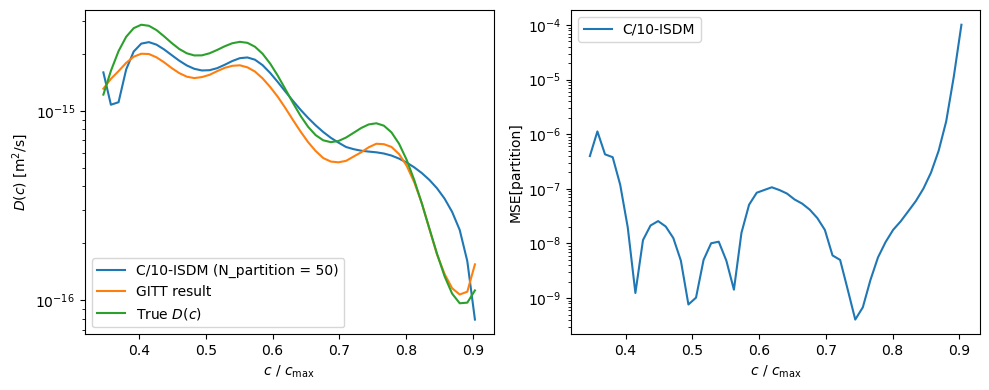

In [26]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(c_aves_all_direct, D_parts_all_direct*D_unit, label="C/10-ISDM (N_partition = {})".format(N_partition))
plt.plot(c_aves_all_direct, D_GITT(c_aves_all_direct)*D_unit, label=r"GITT result")
plt.plot(c_aves_all_direct, D_true_code(c_aves_all_direct)*D_unit, label=r"True $D(c)$")
plt.yscale("log")
plt.xlabel(r"$c~/~c_{\rm max}$")
plt.ylabel(r"$D(c) \mathrm{~[m^2/s]}$")
#plt.title('All data used in cost function')
plt.legend()

plt.subplot(1,2,2)
plt.plot(c_aves_all_direct, mse_parts_all_direct, label="C/10-ISDM")
plt.yscale("log")
plt.xlabel(r"$c~/~c_{\rm max}$")
plt.ylabel("MSE[partition]")
plt.tight_layout()
plt.legend()
plt.show()

We now test the reconstructed $D(c)$ by evolving the diffusion equation for the duration of the data, then computing the MSE over all available data. 

For this, we need to interpolate $D(c)$. 
- We use linear interpolation
- For extrapolation, we use constant boundary values. Note that there has to be some extrapolation since D(c) is only available for the average c, but at the surface, the concentration can go below the minimum average c momentarily.
- We sort the c values and remove ones that correspond to nan diffusion constants.

In [27]:
# Interpolate 
D_ISDM_int = InterpolatedUnivariateSpline(c_aves_all_direct[::-1], D_parts_all_direct[::-1], k=1, ext=3)
D_prime_ISDM_int = lambda x : D_ISDM_int.derivative()(x)

In [28]:
# Solution 
sol_est_ISDM = solve_ivp(calc_RHS, [t_data[idx_in], t_data[-1]], c0*np.ones(N), t_eval = t_data[idx_in:], method='LSODA', 
                    jac = jacobian, args = ((D_ISDM_int, D_prime_ISDM_int, j_int, mas_inv, "fixed"),),
                    events=my_events,
                    max_step= dt_max_global,
                    rtol=1.e-5,
                    atol=1.e-8
                    )
print(sol_est_ISDM.status)

0


In [29]:
# MSE
mse_ISDM = np.mean((V_data[idx_in:] - Ueq_pOCV(sol_est_ISDM.y[-1]))**2)
print(mse_ISDM)

7.45493629701991e-05


In [30]:
# This is the GITT result
# Using both OCV and pOCV for reference
sol_GITT_all = solve_ivp(calc_RHS, [t_data[idx_in], t_data[-1]], c0*np.ones(N), t_eval = t_data[idx_in:], method='LSODA', 
                    jac = jacobian, args =((D_GITT, D_GITT_prime, j_int, mas_inv, "fixed"),),
                    events=my_events,
                    max_step= dt_max_global,
                    rtol=1.e-5,
                    atol=1.e-8
                    )
print(sol_GITT_all.status)
mse_gitt_pOCV = np.mean((V_data[idx_in:] - Ueq_pOCV(sol_GITT_all.y[-1]))**2)
mse_gitt_OCV = np.mean((V_data[idx_in:] - Ueq_GITT(sol_GITT_all.y[-1]))**2)
print(mse_gitt_pOCV , mse_gitt_OCV)

0
0.0017938679365507 2.1191683679311028e-05


In [31]:
# An the GITT result with approximate derivative
sol_GITT_WH_all = solve_ivp(calc_RHS, [t_data[idx_in], t_data[-1]], c0*np.ones(N), t_eval = t_data[idx_in:], method='LSODA', 
                    jac = jacobian, args =((D_GITT_WH, D_GITT_WH_prime, j_int, mas_inv, "fixed"),),
                    events=my_events,
                    max_step= dt_max_global,
                    rtol=1.e-5,
                    atol=1.e-8
                    )
print(sol_GITT_all.status)
mse_gitt_wh_pOCV = np.mean((V_data[idx_in:] - Ueq_pOCV(sol_GITT_WH_all.y[-1]))**2)
mse_gitt_wh_OCV = np.mean((V_data[idx_in:] - Ueq_GITT(sol_GITT_WH_all.y[-1]))**2)
print(mse_gitt_wh_pOCV, mse_gitt_wh_OCV)

0
0.0018486238258189087 1.4050244060884952e-05


In [32]:
# This is the result with the ground truth D(c)
sol_true_all = solve_ivp(calc_RHS, [t_data[idx_in], t_data[-1]], c0*np.ones(N), t_eval = t_data[idx_in:], method='LSODA', 
                    jac = jacobian, args =((D_true_code, D_prime_true_code, j_int, mas_inv, "fixed"),),
                    events=my_events,
                    max_step= dt_max_global,
                    rtol=1.e-5,
                    atol=1.e-8
                    )
print(sol_true_all.status)
mse_true_pOCV = np.mean((V_data[idx_in:] - Ueq_pOCV(sol_true_all.y[-1]))**2)
mse_true_OCV = np.mean((V_data[idx_in:] - Ueq_GITT(sol_true_all.y[-1]))**2)
print(mse_true_pOCV, mse_true_OCV)

0
2.6696818278849136e-05 1.0915524616447634e-05


My result (with pOCV) has a **HIGHER** MSE than GITT (OCV).
Interestingly, the best performance is displayed by the true D(c), both with pOCV and OCV.

In [33]:
# ISDM R^2
print(1-mse_ISDM/np.var(V_data[idx_in:]))

0.9965750761184692


In [34]:
# GITT R^2 (Ueq from pOCV, GITT)
print(1-mse_gitt_pOCV/np.var(V_data[idx_in:]), 1-mse_gitt_OCV/np.var(V_data[idx_in:]))

0.9175866715499521 0.9990264181928404


In [35]:
# GITT_wh R^2 (Ueq from pOCV, GITT)
print(1-mse_gitt_wh_pOCV/np.var(V_data[idx_in:]), 1-mse_gitt_wh_OCV/np.var(V_data[idx_in:]))

0.9150710933432797 0.9993545080131041


In [36]:
# True R^2 (Ueq from pOCV, GITT)
print(1-mse_true_pOCV/np.var(V_data[idx_in:]), 1-mse_true_OCV/np.var(V_data[idx_in:]))

0.9987735029939737 0.9994985223287118


Now $R_D^2$ values for capturing the true $D(c)$.

In [37]:
D_true_vals = D_true_code(c_aves_all_direct)
D_gitt_vals = D_GITT(c_aves_all_direct)
D_gitt_wh_vals = D_GITT_WH(c_aves_all_direct)
var_true_D = np.var(D_true_vals)
print("R_D^2 for D(c):")
print(f"GITT: {1- np.mean((D_gitt_vals-D_true_vals)**2)},      ISDM (after 1st stage): {1- np.mean((D_parts_all_direct-D_true_vals)**2)}")
print(f"GITT [WH]: {1- np.mean((D_gitt_wh_vals-D_true_vals)**2)}")

R_D^2 for D(c):
GITT: 0.8362626869527587,      ISDM (after 1st stage): 0.8869017048119812
GITT [WH]: 0.8589459938422631


This time, the closest is ISDM. Note that we adopt a 2-stage optimisation and so far only the first stage is completed. We now move on to the second stage.

# Gradient Descent

Now for each $\theta_i = \log_{10}D(c_i) - \log_{10}D_{\rm unit}$, we evaluate the **global** loss at $\bar\theta_i\pm\delta \theta$ to estimate
$$
\frac{\partial \mathcal{L}}{\partial \theta_i}\Bigg\vert_{\theta_i=\bar\theta_i} \approx \frac{\mathcal{L}(\bar\theta_i+\delta\theta)- \mathcal{L}(\bar\theta_i-\delta\theta)}{2\,\delta\theta}\,.
$$
This gives us a numerical estimate of the (negative) direction for the gradient descent. Then, for learning rate $\eta$, we define the new parameter:
$$
\tilde{\theta}_i = \bar\theta_i - \eta\,\frac{\partial \mathcal{L}}{\partial \theta_i}\Bigg\vert_{\theta_i=\bar\theta_i}\,.
$$

In [38]:
def create_interpolator(c_values, D_values, partition):
    """
    Creates interpolation functions for a given partition index.

    Args:
    c_values (array-like): The c values for interpolation.
    D_values (array-like): The D values for interpolation.
    partition (int): The index of the D value that will be variable.

    Returns two functions, D(c, theta) and D_prime(c, theta)
    """
    
    # Sort the values for interpolation purposes
    sorted_idx = np.argsort(c_values)
    sorted_c_values = c_values[sorted_idx]
    sorted_D_values = D_values[sorted_idx]
    sorted_partition = np.where(sorted_idx == partition)[0][0]

    def interpolator(c, D_part):
        """ Defines the D(c, theta) to be used in the ODE solver """
        updated_D_values = sorted_D_values.copy()
        updated_D_values[sorted_partition] = D_part  # Change the D value for the partition to D_part
        interp_func = InterpolatedUnivariateSpline(sorted_c_values, updated_D_values, k=1, ext= 3)
        return interp_func(c)

    def interpolator_derivative(c, D_part):
        """ Defines the D_prime(D_part, c) to be used in the ODE solver """
        updated_D_values = sorted_D_values.copy()
        updated_D_values[sorted_partition] = D_part
        interp_func = InterpolatedUnivariateSpline(sorted_c_values, updated_D_values, k=1, ext= 3)
        return interp_func.derivative()(c)

    return interpolator, interpolator_derivative


def predict_para(D, D_prime, theta, j, t_grid, c_in, dt_max, rtol=1.e-5, atol=1.e-8, events = True):
    """Predict the surface concentration for parameterised diffusivity D(c, theta) and its derivative D_prime(c,theta).
    Evaluate at times t_grid, with initial concentration c_in, forced by flux function j
    """
    if events:
        event_list = my_events
    else:
        event_list = []    
    csol = solve_ivp(calc_RHS, [t_grid[0], t_grid[-1]], c_in, t_eval = t_grid, method='LSODA', 
                    jac = jacobian, args = ((D, D_prime, j, mas_inv, theta),),
                    events=event_list,
                    max_step= dt_max,
                     rtol = rtol,
                     atol = atol
                    )
    return csol

Vardata = np.mean((V_data[idx_in:]-np.mean(V_data[idx_in:]))**2)

def Rsquared(c_values, D_values, Ueq, events=False):    
    sorted_idx = np.argsort(c_values)
    sorted_c_values = c_values[sorted_idx]
    sorted_D_values = D_values[sorted_idx]
    
    D_values_int = InterpolatedUnivariateSpline(sorted_c_values, sorted_D_values, k=1, ext= 3)
    D_values_prime_int = lambda x : D_values_int.derivative()(x)
    
    if events:
        event_list = my_events
    else:
        event_list =[]
    # Solution 
    solution = solve_ivp(calc_RHS, [t_data[idx_in], t_data[-1]], c0*np.ones(N), t_eval = t_data[idx_in:], method='LSODA', 
                        jac = jacobian, args = ((D_values_int, D_values_prime_int, j_int, mas_inv, "fixed"),),
                        events=event_list,
                        max_step= dt_max_global,
                        rtol=1.e-5,
                        atol=1.e-8
                        )

    if solution.status == 1:
        print("concentration outside [0,1]")
        return
    else:
        # MSE
        mse = np.mean((V_data[idx_in:] - Ueq(solution.y[-1]))**2)
        # R^2
        rsquared = 1-mse/Vardata
        return rsquared

In [39]:
def gradient_descent(c_aves_all_direct, D_parts_all_direct, Ueq, eta_ini = 1e2, eta_decay = 1, eta_decay_period = 1, N_iter_max = 5, dtheta =1e-4):
    eta_lr = eta_ini

    c_iter = c_aves_all_direct.copy()
    D_iter = D_parts_all_direct.copy()

    R2_iter = Rsquared(c_aves_all_direct, D_parts_all_direct, Ueq)
    R2_iter_last = -np.inf

    # Record the R^2 from each iteration
    R2list = [R2_iter, ]
    # Same for values at the knots for D(c)
    D_iter_list = [D_iter.copy(), ]
    N_iter = 0 # iteration counter

    # Iteration loop here
    while N_iter < N_iter_max:

        N_iter +=1

        counter_display = display(HTML(f"Partition {0}/{N_partition-1}  [Iteration # {N_iter}]"), display_id=True)

        grad_ell_list = []
        # @@@@@Gradient calculation loop
        for part in range(N_partition):
            counter_display.update(HTML(f"Partition {part}/{N_partition-1}  [Iteration # {N_iter}]"))
            # Set up D function
            D_current, D_prime_current = create_interpolator(c_iter, D_iter, part)


            #dt_max_neigh
            D_up = D_iter[part] * 10**dtheta
            D_dn = D_iter[part] * 10**(-dtheta)
            c_up = predict_para(D_current, D_prime_current, D_up, j_int, t_data[idx_in:], np.ones(N)*c0,
                                                    dt_max_global, atol=1.e-8, rtol=1.e-5, events=True)

            c_dn = predict_para(D_current, D_prime_current, D_dn, j_int, t_data[idx_in:], np.ones(N)*c0,
                                                    dt_max_global, atol=1.e-8, rtol=1.e-5, events=True)

            # Approximate the gradient of local loss
            ell_up = np.mean((V_data[idx_in:] - Ueq(c_up.y[-1]))**2)
            ell_dn = np.mean((V_data[idx_in:] - Ueq(c_dn.y[-1]))**2)

            grad_ell = 0.5 * (ell_up-ell_dn) / dtheta
            grad_ell_list += [grad_ell]

        grad_ell_list = np.array(grad_ell_list)
        D_iter = D_iter.copy()*10**(-eta_lr*grad_ell_list)

        R2_iter, R2_iter_last = Rsquared(c_iter, D_iter, Ueq), R2_iter
        R2list += [R2_iter,]
        D_iter_list += [D_iter.copy(),]
        print(f"Changed R^2 from {R2_iter_last:.8f} to {R2_iter:.8f} [learning rate: {eta_lr}]")
        if not (N_iter%eta_decay_period):
            eta_lr *= eta_decay
        D_best = D_iter_list[np.argmax(R2list)]
    return D_best, np.array(D_iter_list), np.array(R2list)

In [40]:
%%time 

eta_ini=400
eta_decay=0.99
eta_decay_period = 2
N_iter_max = 100
dtheta=1e-4
DbestGD, DlistGD, R2listGD = gradient_descent(c_aves_all_direct, D_parts_all_direct, Ueq_pOCV,
                                              eta_ini=eta_ini, eta_decay=eta_decay, 
                                              eta_decay_period=eta_decay_period, 
                                              N_iter_max=N_iter_max, dtheta=dtheta)

Changed R^2 from 0.99657508 to 0.99694585 [learning rate: 400]


Changed R^2 from 0.99694585 to 0.99724652 [learning rate: 400]


Changed R^2 from 0.99724652 to 0.99749557 [learning rate: 396.0]


Changed R^2 from 0.99749557 to 0.99767605 [learning rate: 396.0]


Changed R^2 from 0.99767605 to 0.99784128 [learning rate: 392.04]


Changed R^2 from 0.99784128 to 0.99798962 [learning rate: 392.04]


Changed R^2 from 0.99798962 to 0.99812367 [learning rate: 388.1196]


Changed R^2 from 0.99812367 to 0.99823947 [learning rate: 388.1196]


Changed R^2 from 0.99823947 to 0.99834674 [learning rate: 384.238404]


Changed R^2 from 0.99834674 to 0.99843265 [learning rate: 384.238404]


Changed R^2 from 0.99843265 to 0.99851036 [learning rate: 380.39601996]


Changed R^2 from 0.99851036 to 0.99858801 [learning rate: 380.39601996]


Changed R^2 from 0.99858801 to 0.99865709 [learning rate: 376.5920597604]


Changed R^2 from 0.99865709 to 0.99871971 [learning rate: 376.5920597604]


Changed R^2 from 0.99871971 to 0.99877732 [learning rate: 372.826139162796]


Changed R^2 from 0.99877732 to 0.99883380 [learning rate: 372.826139162796]


Changed R^2 from 0.99883380 to 0.99888206 [learning rate: 369.09787777116804]


Changed R^2 from 0.99888206 to 0.99892801 [learning rate: 369.09787777116804]


Changed R^2 from 0.99892801 to 0.99897421 [learning rate: 365.40689899345637]


Changed R^2 from 0.99897421 to 0.99901654 [learning rate: 365.40689899345637]


Changed R^2 from 0.99901654 to 0.99905531 [learning rate: 361.7528300035218]


Changed R^2 from 0.99905531 to 0.99909243 [learning rate: 361.7528300035218]


Changed R^2 from 0.99909243 to 0.99912600 [learning rate: 358.13530170348656]


Changed R^2 from 0.99912600 to 0.99915547 [learning rate: 358.13530170348656]


Changed R^2 from 0.99915547 to 0.99918393 [learning rate: 354.5539486864517]


Changed R^2 from 0.99918393 to 0.99921375 [learning rate: 354.5539486864517]


Changed R^2 from 0.99921375 to 0.99924138 [learning rate: 351.00840919958716]


Changed R^2 from 0.99924138 to 0.99926676 [learning rate: 351.00840919958716]


Changed R^2 from 0.99926676 to 0.99929097 [learning rate: 347.4983251075913]


Changed R^2 from 0.99929097 to 0.99931464 [learning rate: 347.4983251075913]


Changed R^2 from 0.99931464 to 0.99933604 [learning rate: 344.0233418565154]


Changed R^2 from 0.99933604 to 0.99935789 [learning rate: 344.0233418565154]


Changed R^2 from 0.99935789 to 0.99937701 [learning rate: 340.5831084379502]


Changed R^2 from 0.99937701 to 0.99939607 [learning rate: 340.5831084379502]


Changed R^2 from 0.99939607 to 0.99941324 [learning rate: 337.17727735357073]


Changed R^2 from 0.99941324 to 0.99942975 [learning rate: 337.17727735357073]


Changed R^2 from 0.99942975 to 0.99944683 [learning rate: 333.805504580035]


Changed R^2 from 0.99944683 to 0.99946230 [learning rate: 333.805504580035]


Changed R^2 from 0.99946230 to 0.99947632 [learning rate: 330.4674495342347]


Changed R^2 from 0.99947632 to 0.99949037 [learning rate: 330.4674495342347]


Changed R^2 from 0.99949037 to 0.99950335 [learning rate: 327.16277503889233]


Changed R^2 from 0.99950335 to 0.99951622 [learning rate: 327.16277503889233]


Changed R^2 from 0.99951622 to 0.99952754 [learning rate: 323.8911472885034]


Changed R^2 from 0.99952754 to 0.99953845 [learning rate: 323.8911472885034]


Changed R^2 from 0.99953845 to 0.99955008 [learning rate: 320.6522358156184]


Changed R^2 from 0.99955008 to 0.99955968 [learning rate: 320.6522358156184]


Changed R^2 from 0.99955968 to 0.99956940 [learning rate: 317.4457134574622]


Changed R^2 from 0.99956940 to 0.99957868 [learning rate: 317.4457134574622]


Changed R^2 from 0.99957868 to 0.99958720 [learning rate: 314.27125632288755]


Changed R^2 from 0.99958720 to 0.99959605 [learning rate: 314.27125632288755]


Changed R^2 from 0.99959605 to 0.99960427 [learning rate: 311.12854375965867]


Changed R^2 from 0.99960427 to 0.99961218 [learning rate: 311.12854375965867]


Changed R^2 from 0.99961218 to 0.99962031 [learning rate: 308.0172583220621]


Changed R^2 from 0.99962031 to 0.99962763 [learning rate: 308.0172583220621]


Changed R^2 from 0.99962763 to 0.99963463 [learning rate: 304.93708573884146]


Changed R^2 from 0.99963463 to 0.99964119 [learning rate: 304.93708573884146]


Changed R^2 from 0.99964119 to 0.99964804 [learning rate: 301.88771488145306]


Changed R^2 from 0.99964804 to 0.99965472 [learning rate: 301.88771488145306]


Changed R^2 from 0.99965472 to 0.99966102 [learning rate: 298.86883773263855]


Changed R^2 from 0.99966102 to 0.99966663 [learning rate: 298.86883773263855]


Changed R^2 from 0.99966663 to 0.99967283 [learning rate: 295.88014935531214]


Changed R^2 from 0.99967283 to 0.99967793 [learning rate: 295.88014935531214]


Changed R^2 from 0.99967793 to 0.99968315 [learning rate: 292.92134786175905]


Changed R^2 from 0.99968315 to 0.99968822 [learning rate: 292.92134786175905]


Changed R^2 from 0.99968822 to 0.99969369 [learning rate: 289.99213438314143]


Changed R^2 from 0.99969369 to 0.99969860 [learning rate: 289.99213438314143]


Changed R^2 from 0.99969860 to 0.99970348 [learning rate: 287.09221303931]


Changed R^2 from 0.99970348 to 0.99970845 [learning rate: 287.09221303931]


Changed R^2 from 0.99970845 to 0.99971273 [learning rate: 284.2212909089169]


Changed R^2 from 0.99971273 to 0.99971686 [learning rate: 284.2212909089169]


Changed R^2 from 0.99971686 to 0.99972074 [learning rate: 281.3790779998277]


Changed R^2 from 0.99972074 to 0.99972541 [learning rate: 281.3790779998277]


Changed R^2 from 0.99972541 to 0.99972919 [learning rate: 278.56528721982943]


Changed R^2 from 0.99972919 to 0.99973340 [learning rate: 278.56528721982943]


Changed R^2 from 0.99973340 to 0.99973713 [learning rate: 275.77963434763114]


Changed R^2 from 0.99973713 to 0.99974161 [learning rate: 275.77963434763114]


Changed R^2 from 0.99974161 to 0.99974519 [learning rate: 273.02183800415486]


Changed R^2 from 0.99974519 to 0.99974814 [learning rate: 273.02183800415486]


Changed R^2 from 0.99974814 to 0.99975178 [learning rate: 270.2916196241133]


Changed R^2 from 0.99975178 to 0.99975482 [learning rate: 270.2916196241133]


Changed R^2 from 0.99975482 to 0.99975790 [learning rate: 267.5887034278722]


Changed R^2 from 0.99975790 to 0.99976078 [learning rate: 267.5887034278722]


Changed R^2 from 0.99976078 to 0.99976333 [learning rate: 264.91281639359346]


Changed R^2 from 0.99976333 to 0.99976600 [learning rate: 264.91281639359346]


Changed R^2 from 0.99976600 to 0.99976863 [learning rate: 262.26368822965753]


Changed R^2 from 0.99976863 to 0.99977137 [learning rate: 262.26368822965753]


Changed R^2 from 0.99977137 to 0.99977416 [learning rate: 259.64105134736093]


Changed R^2 from 0.99977416 to 0.99977665 [learning rate: 259.64105134736093]


Changed R^2 from 0.99977665 to 0.99977924 [learning rate: 257.04464083388734]


Changed R^2 from 0.99977924 to 0.99978137 [learning rate: 257.04464083388734]


Changed R^2 from 0.99978137 to 0.99978340 [learning rate: 254.47419442554846]


Changed R^2 from 0.99978340 to 0.99978547 [learning rate: 254.47419442554846]


Changed R^2 from 0.99978547 to 0.99978724 [learning rate: 251.92945248129297]


Changed R^2 from 0.99978724 to 0.99978965 [learning rate: 251.92945248129297]


Changed R^2 from 0.99978965 to 0.99979162 [learning rate: 249.41015795648005]


Changed R^2 from 0.99979162 to 0.99979338 [learning rate: 249.41015795648005]


Changed R^2 from 0.99979338 to 0.99979525 [learning rate: 246.91605637691524]


Changed R^2 from 0.99979525 to 0.99979738 [learning rate: 246.91605637691524]


Changed R^2 from 0.99979738 to 0.99979960 [learning rate: 244.44689581314609]


Changed R^2 from 0.99979960 to 0.99980152 [learning rate: 244.44689581314609]
CPU times: user 16min 47s, sys: 616 ms, total: 16min 47s
Wall time: 16min 47s


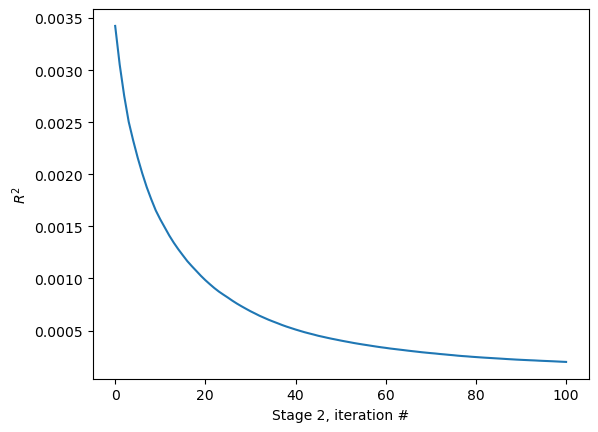

In [41]:
plt.plot(1-R2listGD)
plt.xlabel("Stage 2, iteration #")
plt.ylabel(r"$R^2$")
plt.show()

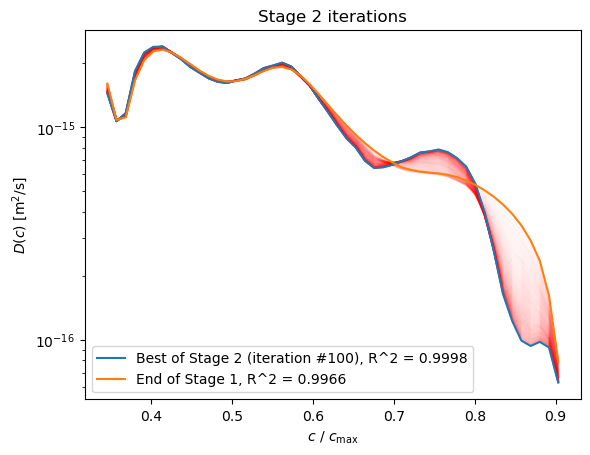

In [42]:
for i, DD in enumerate(DlistGD):
    alph = (len(DlistGD)-i)/len(DlistGD)
    plt.plot(c_aves_all_direct, DD*D_unit, 'r', alpha = 0.05)
plt.plot(c_aves_all_direct, DbestGD*D_unit, label = f"Best of Stage 2 (iteration #{np.argmax(R2listGD)}), R^2 = {np.max(R2listGD):.4f}")
plt.plot(c_aves_all_direct, D_parts_all_direct*D_unit, label= f"End of Stage 1, R^2 = {R2listGD[0]:.4f}")
plt.yscale("log")
plt.legend()
plt.xlabel(r"$c~/~c_{\rm max}$")
plt.ylabel(r"$D(c) \mathrm{~[m^2/s]}$")
plt.title("Stage 2 iterations")
plt.show()

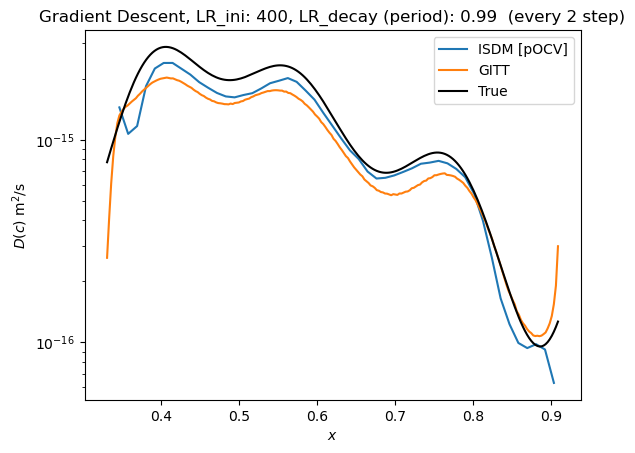

In [43]:
plt.plot(c_aves_all_direct, D_unit*DbestGD, label="ISDM [pOCV]",)
plt.plot(df_D_GITT.c_cmax, df_D_GITT.D_SI , label = "GITT")
plt.plot(df_D_GITT.c_cmax, D_c_true(df_D_GITT.c_cmax),'k',  label = "True")
plt.yscale("log")
plt.title(f"Gradient Descent, LR_ini: {eta_ini}, LR_decay (period): {eta_decay}  (every {eta_decay_period} step)")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$D(c)\mathrm{~m^2/s}$")
plt.show()

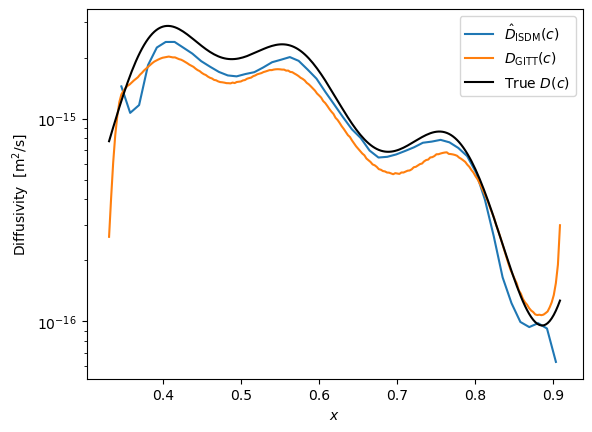

In [44]:
plt.plot(c_aves_all_direct, D_unit*DbestGD, label=r"$\hat{D}_{\rm ISDM}(c)$")
plt.plot(df_D_GITT.c_cmax, df_D_GITT.D_SI , label = r"$D_{\rm GITT}(c)$")
plt.plot(df_D_GITT.c_cmax, D_c_true(df_D_GITT.c_cmax),'k',  label = r"True $D(c)$")
plt.yscale("log")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"Diffusivity $\mathrm{~[m^2/s]}$")
plt.show()


In [45]:
D_true_vals = D_c_true(c_aves_all_direct)
D_gitt_vals = D_GITT(c_aves_all_direct)*D_unit
D_gitt_wh_vals = D_GITT_WH(c_aves_all_direct)*D_unit
var_true_D = np.var(D_true_vals)
print("R_D^2 for D(c):")
print(f"GITT: {1- np.mean((D_gitt_vals-D_true_vals)**2)/var_true_D},      ISDM: {1- np.mean((DbestGD*D_unit-D_true_vals)**2)/var_true_D}")
print(f"GITT [WH]: {1- np.mean((D_gitt_wh_vals-D_true_vals)**2)/var_true_D}")

R_D^2 for D(c):
GITT: 0.7812159434885112,      ISDM: 0.8835534885947974
GITT [WH]: 0.8115251369400303


In [46]:
print("R^2 for data:")
print(f"\
        ISDM     : {np.max(R2listGD)}\n\
        TRUE     : {1-mse_true_OCV/np.var(V_data[idx_in:])} [OCV]\n\
        GITT [WH]: {1-mse_gitt_wh_OCV/np.var(V_data[idx_in:])} [OCV]\n\
        GITT     : {1-mse_gitt_OCV/np.var(V_data[idx_in:])} [OCV]\n\
        TRUE     : {1-mse_true_pOCV/np.var(V_data[idx_in:])} [pOCV]\n\
        GITT     : {1-mse_gitt_pOCV/np.var(V_data[idx_in:])} [pOCV]\n\
        GITT [WH]: {1-mse_gitt_wh_pOCV/np.var(V_data[idx_in:])} [pOCV]\n\
        "
     )

R^2 for data:
        ISDM     : 0.9998015215666001
        TRUE     : 0.9994985223287118 [OCV]
        GITT [WH]: 0.9993545080131041 [OCV]
        GITT     : 0.9990264181928404 [OCV]
        TRUE     : 0.9987735029939737 [pOCV]
        GITT     : 0.9175866715499521 [pOCV]
        GITT [WH]: 0.9150710933432797 [pOCV]
        


In [47]:
df_data = pd.DataFrame(data=np.vstack([c_aves_all_direct, DlistGD]).T, columns= ['c'] + ['iter#{}'.format(i) for i in range(len(DlistGD))])

In [48]:
df_R2 = pd.DataFrame(data = R2listGD.reshape(1,-1),  columns= ['iter#{}'.format(i) for i in range(len(DlistGD))], index=["R^2"]).reindex(columns=df_data.columns)

In [49]:
df_output = pd.concat([df_R2, df_data])

In [50]:
df_output.to_csv(inference_save_dir + 'D_ISDM_050_01C_pOCV.csv')

Better definition $R_V^2$, using deviation of $V$ from $U_{\rm eq}$

## $R^2$ measures

We have several $R^2$ measures. First, the $R^2$ defining the explained variation in the data:
$$
R^2 = 1 - \frac{{\rm MSE}(V_{pred}, V_{data})}{{\rm Var}(V_{data})}\,.
$$

We define a modified $R_V^2$ measure that quantifies the fraction of the variability in the voltage, after the reference $V_{ref}$ is removed:
$$
R_V^2 = 1 - \frac{{\rm MSE}(V_{pred}, V_{data})}{{\rm Var}(V_{data}-V_{ref})}\,,
$$
where $V_{ref}$ can be any of the null models. The most obvious is the $U_{\rm eq}(c_{\rm surf})$ for $D\to \infty$ case, which essentially determines how well the model explains departures from the (real) equilibrium potential $U_{\rm eq}(c_{\rm av})$


In [51]:
%%time 
from multiprocessing import Pool
from scipy.integrate import quad

I_SI_int = InterpolatedUnivariateSpline(t_SI, I_SI, k=1)  
# Charge transferred in one step in t_SI
def delta_Q_step(i):
    return quad(I_SI_int, t_SI[i-1], t_SI[i], points=t_SI)[0]

# Do these in parallel
with Pool() as pool:
    delta_Q_SI = pool.map(delta_Q_step, range(1, len(t_SI)))

# Add zero to initialise.
delta_Q_SI = np.r_[0, delta_Q_SI]

# Accumulated charge at each time in t_SI
Q_SI = np.cumsum(delta_Q_SI)
c_surf_null_inf = c0 - Q_SI[idx_in:] / F/Np/V_particle/cmax_SI[1]

CPU times: user 21.6 ms, sys: 73 ms, total: 94.6 ms
Wall time: 121 ms


In [52]:
# Interpolate 
D_ISDMbest_int = InterpolatedUnivariateSpline(c_aves_all_direct[::-1], DbestGD[::-1], k=1, ext=3)
D_prime_ISDMbest_int = lambda x : D_ISDMbest_int.derivative()(x)

In [53]:
# Solution 
sol_est_ISDMbest = solve_ivp(calc_RHS, [t_data[idx_in], t_data[-1]], c0*np.ones(N), t_eval = t_data[idx_in:], method='LSODA', 
                    jac = jacobian, args = ((D_ISDMbest_int, D_prime_ISDMbest_int, j_int, mas_inv, "fixed"),),
                    events=my_events,
                    max_step= dt_max_global,
                    rtol=1.e-5,
                    atol=1.e-8
                    )
print(sol_est_ISDMbest.status)

0


In [54]:
V_GITT_OCV = Ueq_GITT(sol_GITT_all.y[-1])
V_GITT_pOCV = Ueq_pOCV(sol_GITT_all.y[-1])
V_GITT_WH_OCV = Ueq_GITT(sol_GITT_WH_all.y[-1])
V_GITT_WH_pOCV = Ueq_pOCV(sol_GITT_WH_all.y[-1])
V_true_OCV = Ueq_GITT(sol_true_all.y[-1])
V_true_pOCV = Ueq_pOCV(sol_true_all.y[-1])
V_null_OCV = Ueq_GITT(c_surf_null_inf)
V_null_pOCV = Ueq_pOCV(c_surf_null_inf)

V_ISDMbest_OCV = Ueq_GITT(sol_est_ISDMbest.y[-1])
V_ISDMbest_pOCV = Ueq_pOCV(sol_est_ISDMbest.y[-1])

VAR_V_data_OCV = np.var(V_data-V_null_OCV)

In [55]:
print("R^2hat for data:")
print(f"\
        ISDM   [pOCV]: { 1- np.mean((V_ISDMbest_pOCV - V_data)**2)/VAR_V_data_OCV}\n\
        ISDM   [OCV] : { 1- np.mean((V_ISDMbest_OCV - V_data)**2)/VAR_V_data_OCV}\n\
        TRUE   [pOCV]: { 1- np.mean((V_true_pOCV - V_data)**2)/VAR_V_data_OCV}\n\
        TRUE   [OCV] : { 1- np.mean((V_true_OCV - V_data)**2)/VAR_V_data_OCV}\n\
        GITT   [pOCV]: { 1- np.mean((V_GITT_pOCV - V_data)**2)/VAR_V_data_OCV}\n\
        GITT   [OCV] : { 1- np.mean((V_GITT_OCV - V_data)**2)/VAR_V_data_OCV}\n\
        GITT_WH[pOCV]: { 1- np.mean((V_GITT_WH_pOCV - V_data)**2)/VAR_V_data_OCV}\n\
        GITT_WH[OCV] : { 1- np.mean((V_GITT_WH_OCV - V_data)**2)/VAR_V_data_OCV}\n\
        "
     )
        

R^2hat for data:
        ISDM   [pOCV]: 0.9682592982303382
        ISDM   [OCV] : 0.9902760567542113
        TRUE   [pOCV]: 0.8038584090836065
        TRUE   [OCV] : 0.91980361323981
        GITT   [pOCV]: -12.179552233298198
        GITT   [OCV] : 0.8443046468069145
        GITT_WH[pOCV]: -12.581843889215005
        GITT_WH[OCV] : 0.896772821611895
        
